# Inputs

In [ ]:
import os
file_names = os.listdir('327')

# Import packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np
import scipy.optimize as opt
from scipy.stats import t
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
# %matplotlib widget

# Load data

In [ ]:
# Read the data and pulse times from filenames
data = []
pulse_times = []
for file_name in file_names:
    # Assumes the file name format has the pulse time (in us) before 'us'
    pulse_time = int(file_name.split('/')[-1].split('_')[0])
    df = pd.read_csv(file_name, header=None, names=['t', 'CH1', 'CH2'])
    df = df.dropna()
    df = df[df['t'] > 0.001]
    data.append(df)
    pulse_times.append(pulse_time)

In [6]:
# # Plot the data
# fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# for i, df in enumerate(data):
#     axs[0].plot(df['t'], df['CH1'], label=f'{freqs[i]} Hz')
#     axs[1].plot(df['t'], df['CH2'], label=f'{freqs[i]} Hz')
# axs[0].set_title('CH1')
# axs[1].set_title('CH2')
# axs[0].legend()
# axs[1].legend()
# plt.show()

# Fit envelope to decaying exponential

    Dataset  Pulse Time (us)  Real_T2star  Imag_T2star
0         1               40     0.001040     0.000829
1         2               42     0.000997     0.001326
2         3               44     0.000718     0.000884
3         4               46     0.000894     0.001200
4         5               48     0.000851     0.001205
5         6               50     0.000876     0.000982
6         7               52     0.001303     0.001175
7         8               54     0.000902     0.001599
8         9               56     0.001040     0.000973
9        10               58     0.001445     0.000927
10       11               60     0.001119     0.002104


/var/folders/px/wy4h6r3d0pjcgpg5tm4lrp9h0000gn/T/ipykernel_51718/2394014539.py:46: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_imag, _ = curve_fit(model_exp, t_peaks_imag, amp_peaks_imag, p0=p0_imag)
/var/folders/px/wy4h6r3d0pjcgpg5tm4lrp9h0000gn/T/ipykernel_51718/2394014539.py:33: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_real, _ = curve_fit(model_exp, t_peaks_real, amp_peaks_real, p0=p0_real)


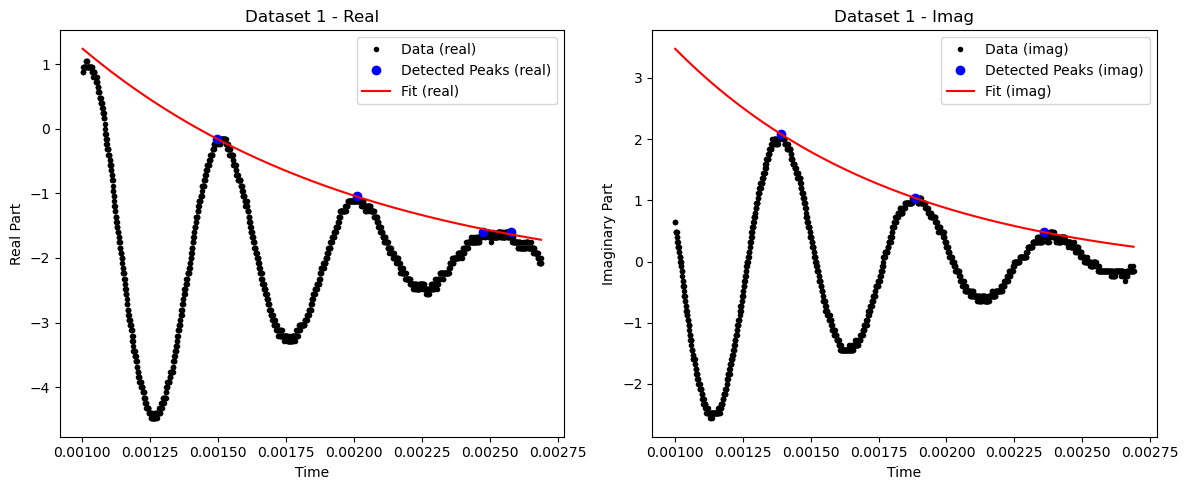

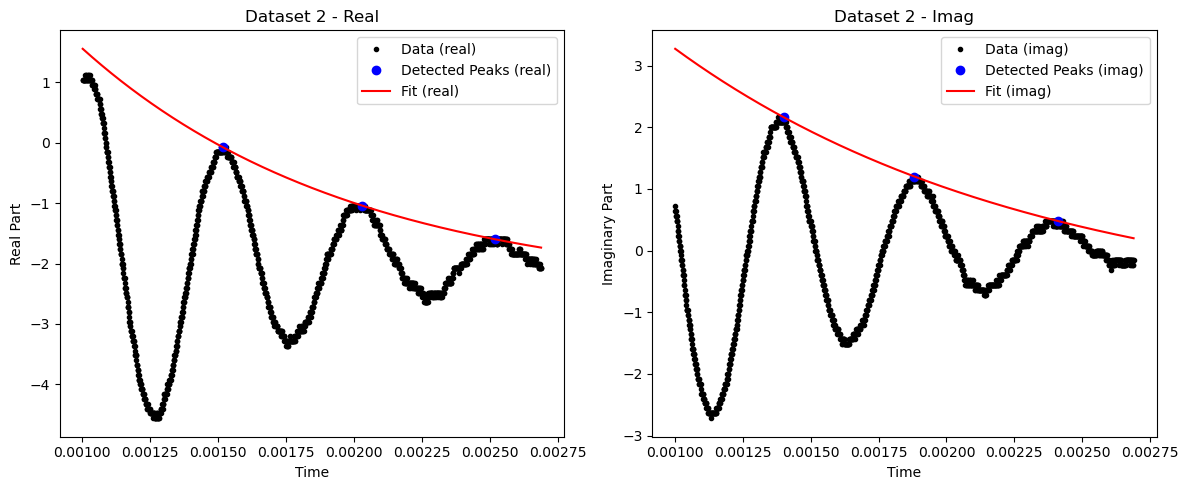

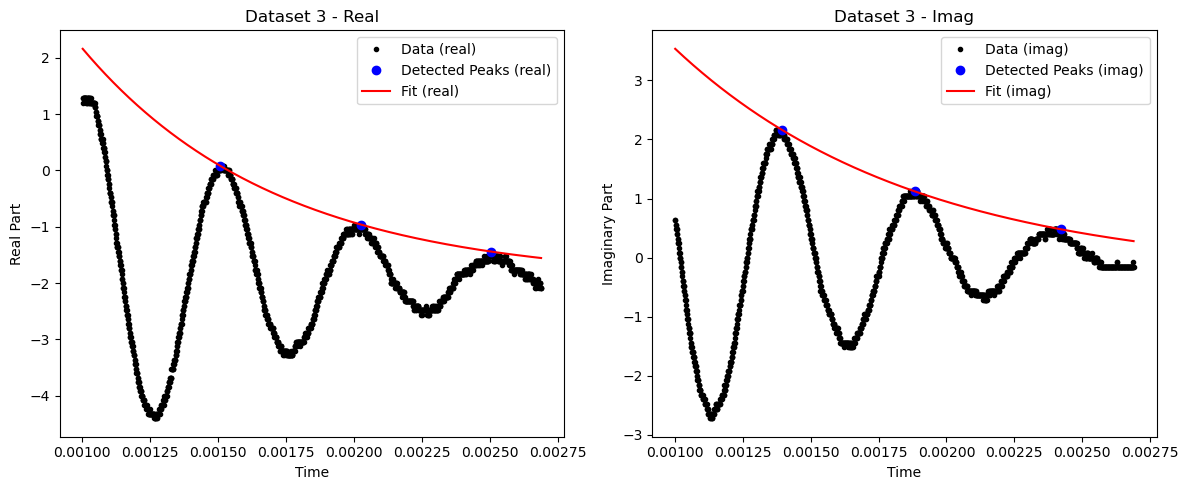

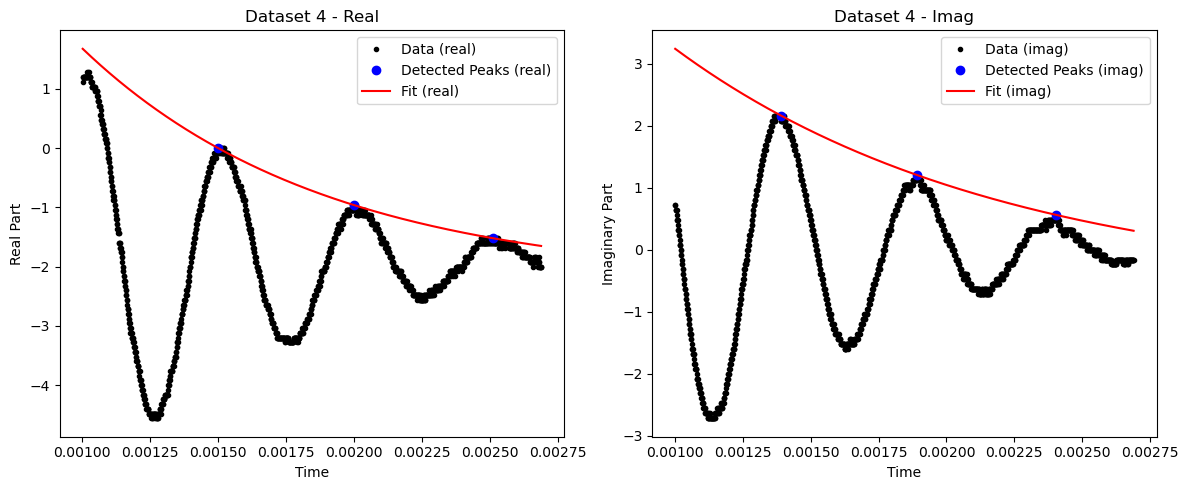

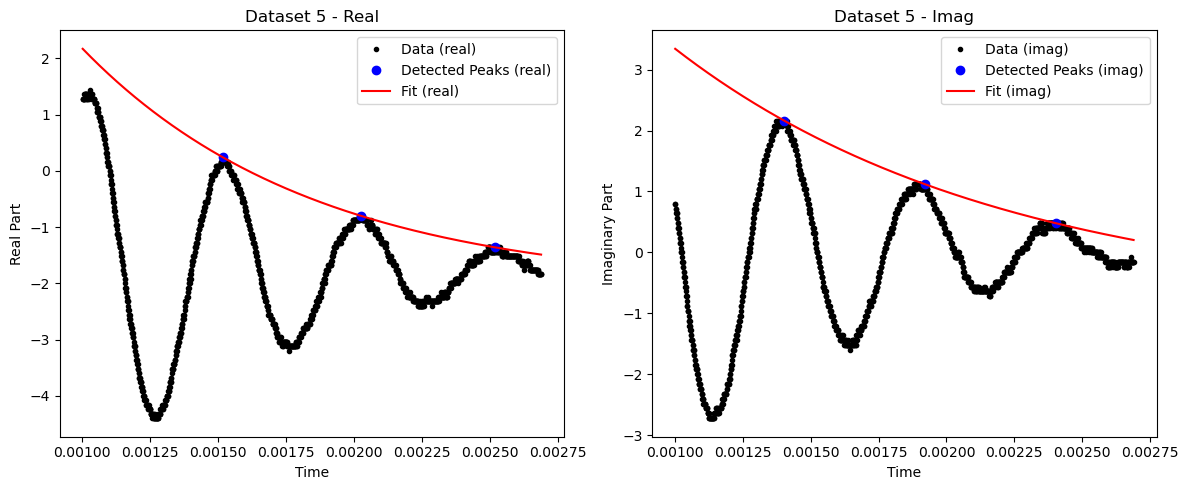

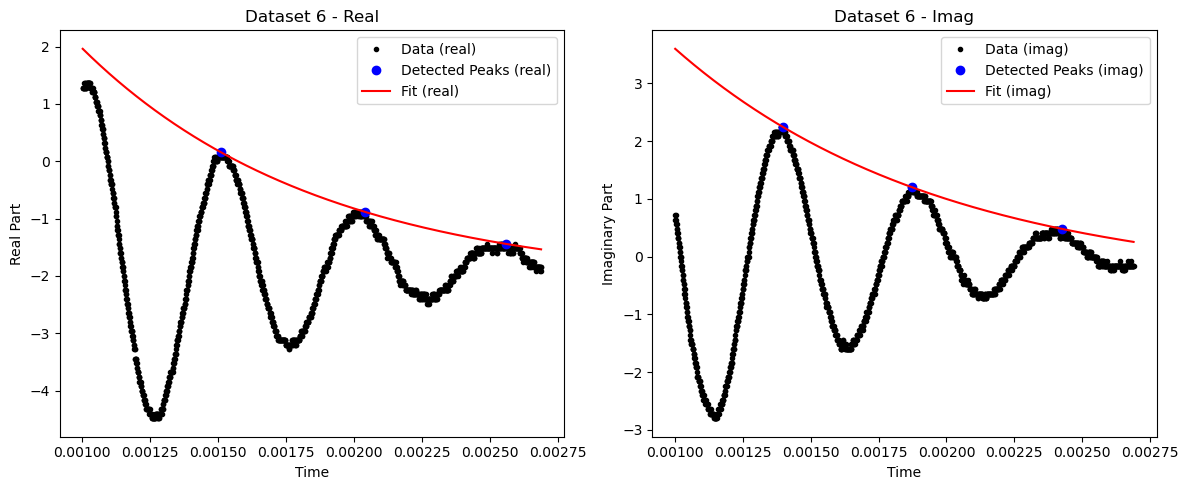

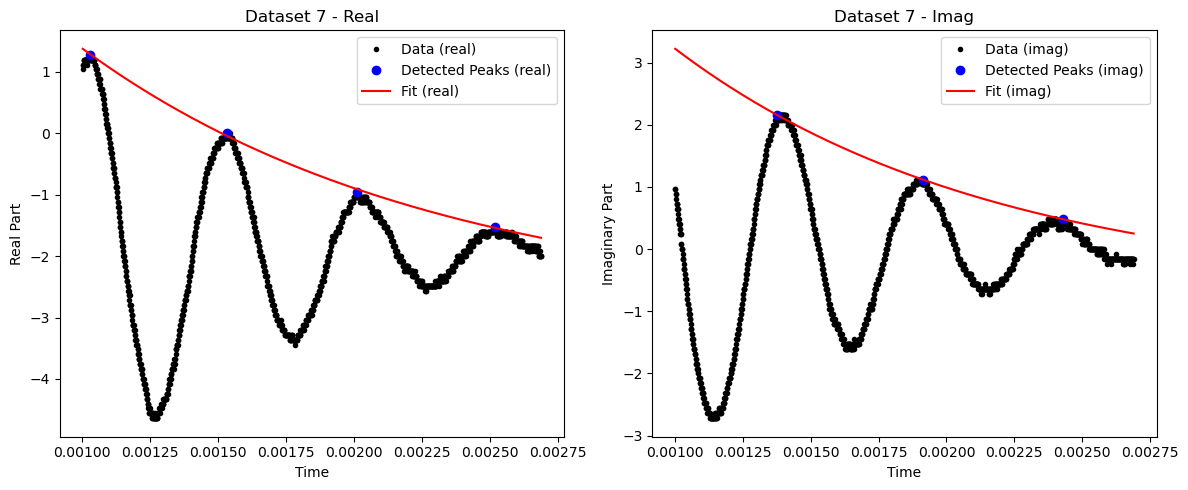

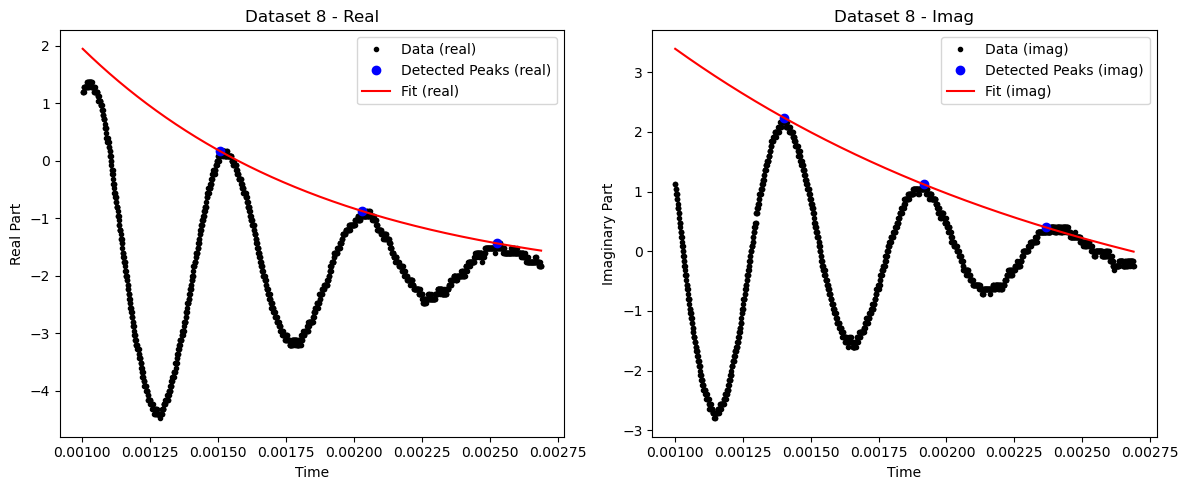

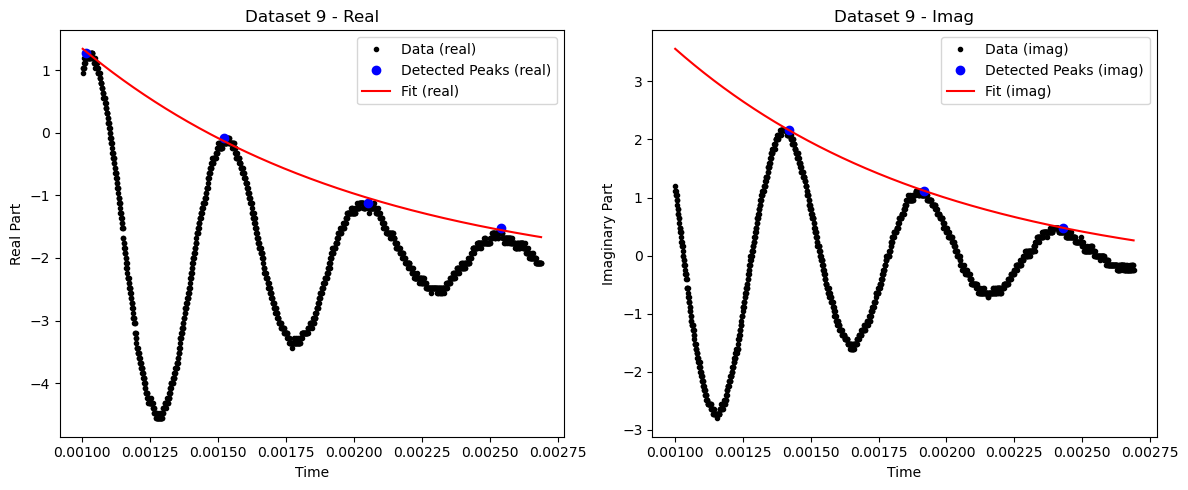

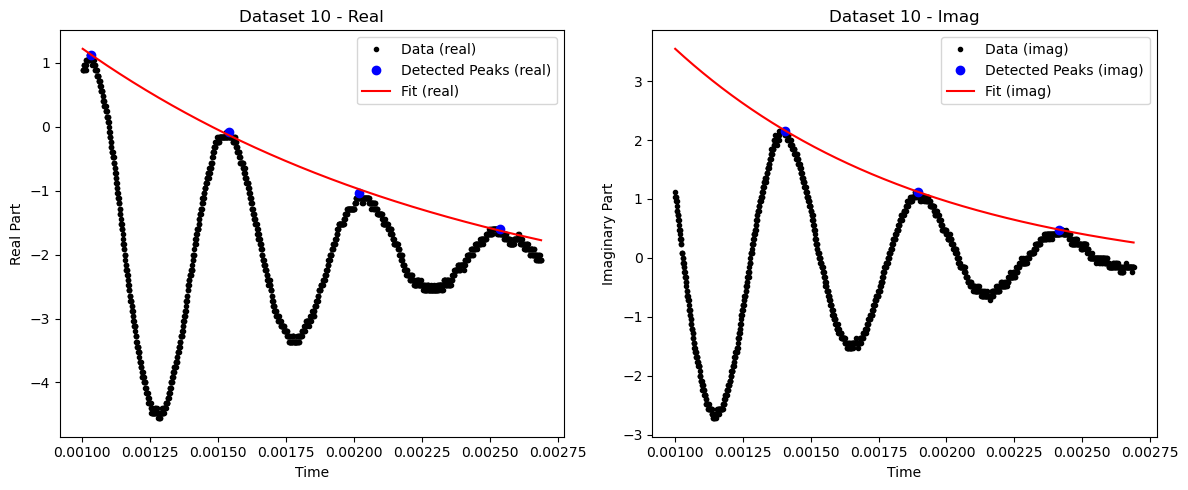

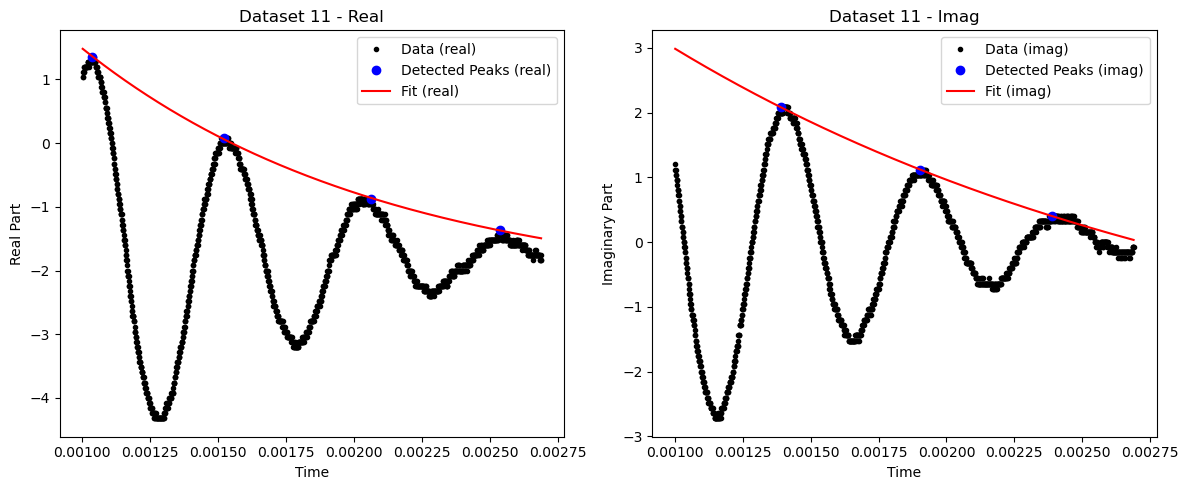

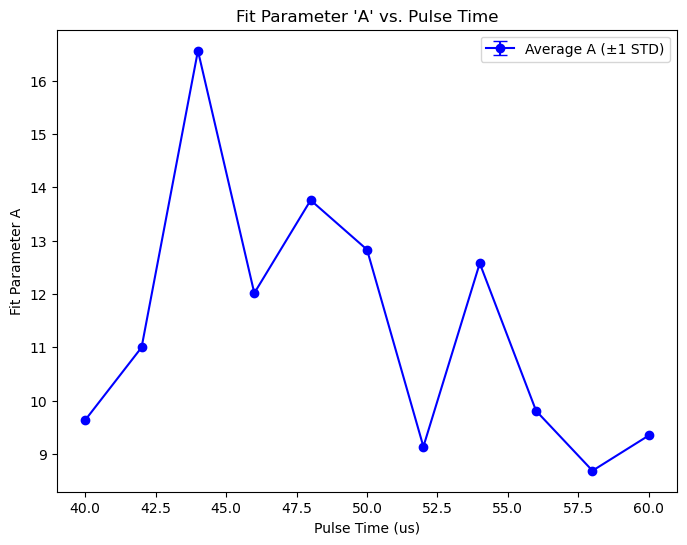

In [8]:
# Simple decaying-exponential model
def model_exp(t, A, T2star, C):
    """
    A * exp(-t/T2star) + C
    """
    return A * np.exp(-t / T2star) + C

results = []
fits = []

# Parameters for peak detection
prominence_value = 0.2
min_distance = 100  # adjust as needed

# Loop over each dataset (with corresponding pulse time)
for idx, (df, pulse_time) in enumerate(zip(data, pulse_times)):
    t = df['t'].values
    real_signal = df['CH1'].values
    imag_signal = df['CH2'].values

    # ------------------
    # 1) DETECT PEAKS FOR REAL PART
    # ------------------
    peak_indices_real, _ = find_peaks(real_signal, prominence=prominence_value, distance=min_distance)
    t_peaks_real = t[peak_indices_real]
    amp_peaks_real = real_signal[peak_indices_real]

    # Fit a decaying exponential to the peaks for the real part
    if len(t_peaks_real) < 3:
        popt_real = [np.nan, np.nan, np.nan]
    else:
        p0_real = [amp_peaks_real[0], (t.max() - t.min()) / 2.0, np.min(amp_peaks_real)]
        popt_real, _ = curve_fit(model_exp, t_peaks_real, amp_peaks_real, p0=p0_real)
    
    # ------------------
    # 2) DETECT PEAKS FOR IMAG PART
    # ------------------
    peak_indices_imag, _ = find_peaks(imag_signal, prominence=prominence_value, distance=min_distance)
    t_peaks_imag = t[peak_indices_imag]
    amp_peaks_imag = imag_signal[peak_indices_imag]

    if len(t_peaks_imag) < 3:
        popt_imag = [np.nan, np.nan, np.nan]
    else:
        p0_imag = [amp_peaks_imag[0], (t.max() - t.min()) / 2.0, np.min(amp_peaks_imag)]
        popt_imag, _ = curve_fit(model_exp, t_peaks_imag, amp_peaks_imag, p0=p0_imag)

    # Store results (here we're storing the T2* parameters as an example)
    results.append({
        'Dataset': idx + 1,
        'Pulse Time (us)': pulse_time,
        'Real_T2star': popt_real[1],
        'Imag_T2star': popt_imag[1]
    })

    # Keep for plotting later; note we don't use frequencies now.
    fits.append((t, real_signal, imag_signal, 
                 peak_indices_real, peak_indices_imag,
                 popt_real, popt_imag))

# Display summary results
results_df = pd.DataFrame(results)
print(results_df)

# ------------------
# PLOTTING THE FITS FOR EACH DATASET
# ------------------
for idx, (t, real_signal, imag_signal,
          peak_indices_real, peak_indices_imag,
          popt_real, popt_imag) in enumerate(fits):
    
    # Compute fitted curves over the entire time for visualization
    fitted_env_real = model_exp(t, *popt_real) if not np.isnan(popt_real).any() else None
    fitted_env_imag = model_exp(t, *popt_imag) if not np.isnan(popt_imag).any() else None

    plt.figure(figsize=(12, 5))

    # ----- Real part -----
    plt.subplot(1, 2, 1)
    plt.plot(t, real_signal, 'k.', label='Data (real)')
    plt.plot(t[peak_indices_real], real_signal[peak_indices_real],
             marker='o', color='blue', linestyle='none',
             label='Detected Peaks (real)')
    if fitted_env_real is not None:
        plt.plot(t, fitted_env_real, 'r-', label='Fit (real)')
    plt.xlabel('Time')
    plt.ylabel('Real Part')
    plt.title(f'Dataset {idx+1} - Real')
    plt.legend()

    # ----- Imag part -----
    plt.subplot(1, 2, 2)
    plt.plot(t, imag_signal, 'k.', label='Data (imag)')
    plt.plot(t[peak_indices_imag], imag_signal[peak_indices_imag],
             marker='o', color='blue', linestyle='none',
             label='Detected Peaks (imag)')
    if fitted_env_imag is not None:
        plt.plot(t, fitted_env_imag, 'r-', label='Fit (imag)')
    plt.xlabel('Time')
    plt.ylabel('Imaginary Part')
    plt.title(f'Dataset {idx+1} - Imag')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ------------------
# PLOTTING THE 'A' FIT PARAMETER VS. PULSE TIME
# ------------------
# Here we use the 'A' parameter from the real-part fit as the scale.
pulse_A = [popt_real[0] for (_, _, _, _, _, popt_real, _) in fits]
df_A = pd.DataFrame({'Pulse Time (us)': pulse_times, 'A': pulse_A})
grouped_A = df_A.groupby('Pulse Time (us)')['A'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(8, 6))
plt.errorbar(grouped_A['Pulse Time (us)'], grouped_A['mean'], yerr=grouped_A['std'],
             fmt='bo-', capsize=5, label="Average A (±1 STD)")
plt.xlabel('Pulse Time (us)')
plt.ylabel('Fit Parameter A')
plt.title("Fit Parameter 'A' vs. Pulse Time")
plt.legend()
plt.show()